# Model Study

### INIT

In [2]:
%load_ext autoreload
%autoreload 2

import os
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp
import seaborn as sb
import pandas as pd
import matplotlib.pyplot as plt

import re
from tqdm import tqdm
import timeit

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [4]:
treeiter = TreeIter([ Tree(fn) for fn in fc.sr.NMSSM_List ])

In [5]:
for point in treeiter:
    mx=int(ak.mean(point["gen_X_m"]))
    my=int(ak.mean(point["gen_Y_m"]))
    point.sample = f"Mx{mx}_My{my}"
    if not (mx==700 and my==400): point.color = None

In [6]:
def count_all_higgs(jet_signalId):
    has_hx = (ak.any(jet_signalId == 0,axis=-1) & ak.any(jet_signalId == 1,axis=-1))
    has_h1y = (ak.any(jet_signalId == 2,axis=-1) & ak.any(jet_signalId == 3,axis=-1))
    has_h2y = (ak.any(jet_signalId == 4,axis=-1) & ak.any(jet_signalId == 5,axis=-1))

    nhiggs = 1*has_hx + 1*has_h1y + 1*has_h2y
    return nhiggs

In [7]:
treeiter.extend(kwargs=lambda tree: dict(
    nfound_nn_all_h=count_all_higgs(tree.nn_jet_signalId),
    nfound_t6_all_h=count_all_higgs(tree.t6_jet_signalId)
))

treeiter.extend(kwargs=lambda tree: dict(
    nn_6j_eff=safe_divide(tree.nfound_nn, tree.nfound_presel, default=1),
    nn_3d_eff=safe_divide(tree.nfound_nn_h, tree.nfound_nn_all_h, default=1),
    nn_2j_avg=ak.mean(tree.nn_higgs_2j_score,axis=-1),
    nn_2j_min=ak.min(tree.nn_higgs_2j_score,axis=-1),
    nn_2j_max=ak.max(tree.nn_higgs_2j_score,axis=-1),
    nn_invm0_eff=safe_divide(tree.nn_invm0, tree.gen_X_m, default=1),
    nn_invm0_diff=tree.gen_X_m-tree.nn_invm0,

    t6_eff=safe_divide(tree.nfound_t6, tree.nfound_presel, default=1),
    d_hhh_eff=safe_divide(tree.nfound_t6_h, tree.nfound_t6_all_h, default=1),
    t6_invm0_eff=safe_divide(tree.t6_invm0, tree.gen_X_m, default=1),
    t6_invm0_diff=tree.gen_X_m-tree.t6_invm0,
))


[None, None, None, None, None, None, None]

In [8]:
varinfo.nfound_presel = dict(bins=range(8),xlabel="N Presel Signal Jets")
varinfo.nfound_nn = dict(bins=range(8),xlabel="N NN6j Signal Jets")
varinfo.nfound_t6 = dict(bins=range(8),xlabel="N T6j Signal Jets")
varinfo.nn_6j_eff = dict(bins=None,xlabel="NN6j Signal Jet Eff")
varinfo.t6_eff = dict(bins=None,xlabel="T6j Signal Jet Eff")

varinfo.nfound_presel_h = dict(bins=range(5),xlabel="N Presel Higgs")
varinfo.nfound_nn_all_h = dict(bins=range(5),xlabel="N NN6j Higgs")
varinfo.nfound_nn_h = dict(bins=range(5),xlabel="N NN3d Higgs")
varinfo.nfound_t6_all_h = dict(bins=range(5),xlabel="N T6j Higgs")
varinfo.nfound_t6_h = dict(bins=range(5),xlabel="N DHHH Higgs")
varinfo.nn_3d_eff = dict(bins=None,xlabel="NN3d Higgs Eff")
varinfo.d_hhh_eff = dict(bins=None,xlabel="DHHH Signal Jet Eff")

In [9]:

def graph_signal(ydata,ylabel=None,xlabels=treeiter.sample,figax=None,set={}):
    fig,ax = graph_multi(range(7),ydatalist=[ydata[:,0]],yerrs=[ydata[:,1]],ylabel=ylabel,figax=figax)
    ax.set_xticks(list(range(7)))
    ax.set_xticklabels(xlabels,rotation=45);
    ax.set(**set)
    return fig,ax
def graph_violin(ydata,ylabel=None,xlabels=treeiter.sample,figax=None):
    if figax is None: figax = plt.subplots()
    fig,ax = figax 

    ax.violinplot(ydata)
    ax.set(xticks=list(range(1,8)),ylabel=ylabel)
    ax.set_xticklabels(xlabels,rotation=45);
    return fig,ax
def graph_boxplot(ydata,ylabel=None,xlabels=treeiter.sample,figax=None):
    if figax is None: figax = plt.subplots()
    fig,ax = figax 

    ax.boxplot(ydata)
    ax.set(xticks=list(range(1,8)),ylabel=ylabel)
    ax.set_xticklabels(xlabels,rotation=45);
    return fig,ax

In [11]:
model_2j = Model("/uscms_data/d3/ekoenig/6BAnalysis/CMSSW_10_2_18/src/sixB/analysis/sixBanalysis/models/2jet_classifier")
triH_list = [ nn2j.process(tree,model_2j) for tree in sixbiter ]
truH_list = [ data[data.nhiggs==3] for data in triH_list ]

100%|██████████| 15/15 [00:04<00:00,  3.28it/s]


## Introduction

Wanted to look into how the NNs were performing for different mass points. 

Using the the selections defined as

* Trigger: HLT\_PFHT330PT30\_QuadPFJet\_75\_60\_45\_40\_TriplePFBTagDeepCSV\_4p5
* Jets are filtered with preselection criteria
    * Jets $P_{T} > 20$ GeV
    * Jet $|\eta| < 2.5$
    * Pass Jet ID
    * Pass Jet PU ID for Jet $P_T<50$ GeV
* Require at least 6 jets to pass
* Jets are ordered in highest b-tag biased $P_{T}$
* 1st jet $P_T$>60 GeV \& tight b-tag
* 2nd jet $P_T$>40 GeV \& tight b-tag
* 3rd jet $P_T$>40 GeV \& medium b-tag
* 4th jet $P_T$>20 GeV \& medium b-tag

## Study

### Cutflow

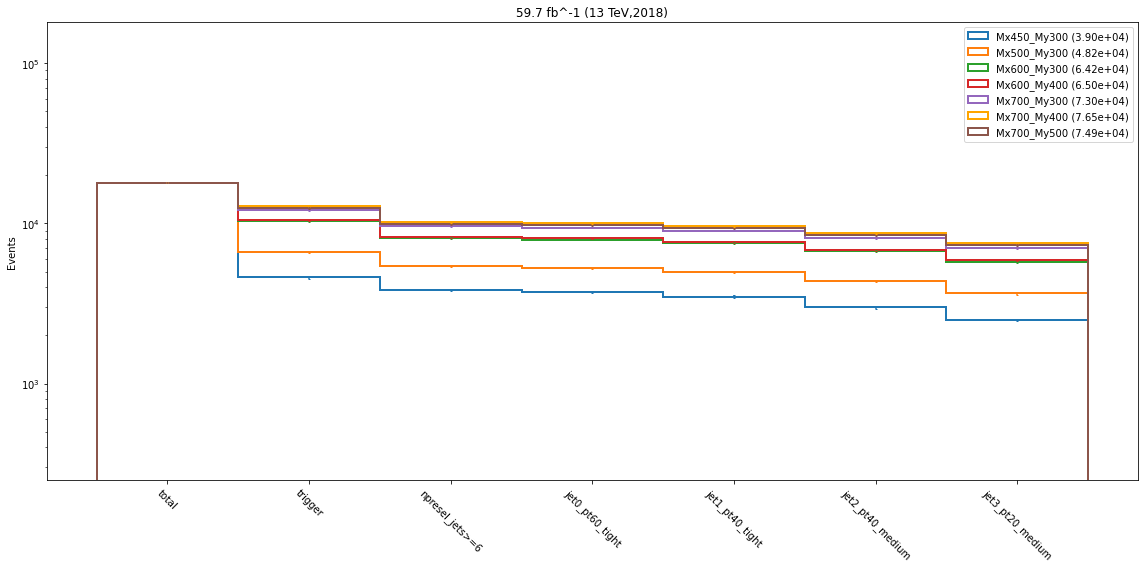

In [12]:
study.cutflow(treeiter)

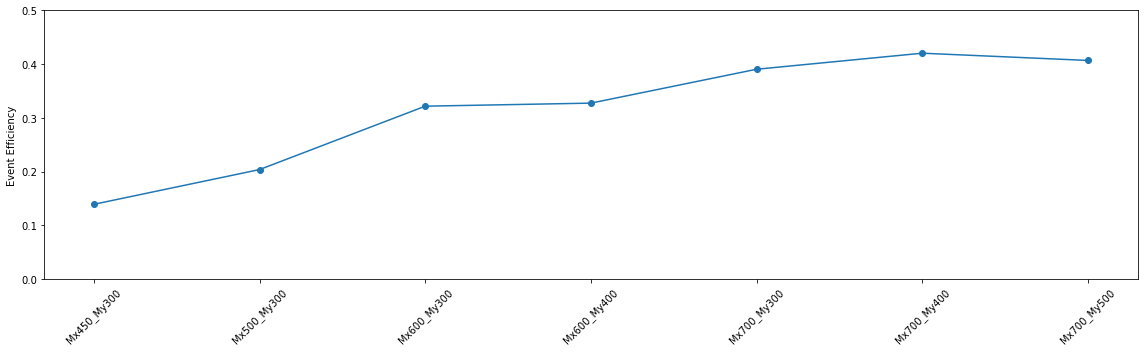

In [13]:
def event_eff(tree,ncut=-1):
    cutflow = ak.sum(tree.cutflow,axis=0)
    eff = cutflow[ncut]/cutflow[0]
    err = eff*np.sqrt(1/cutflow[ncut]+1/cutflow[0])
    return (eff,err) 

fig,axs = plt.subplots(figsize=(16,5))
sp_data = np.array([ event_eff(point) for point in treeiter ])
fig,ax = graph_signal(sp_data,ylabel="Event Efficiency",figax=(fig,axs),set=dict(ylim=(0,0.5)));
fig.tight_layout()

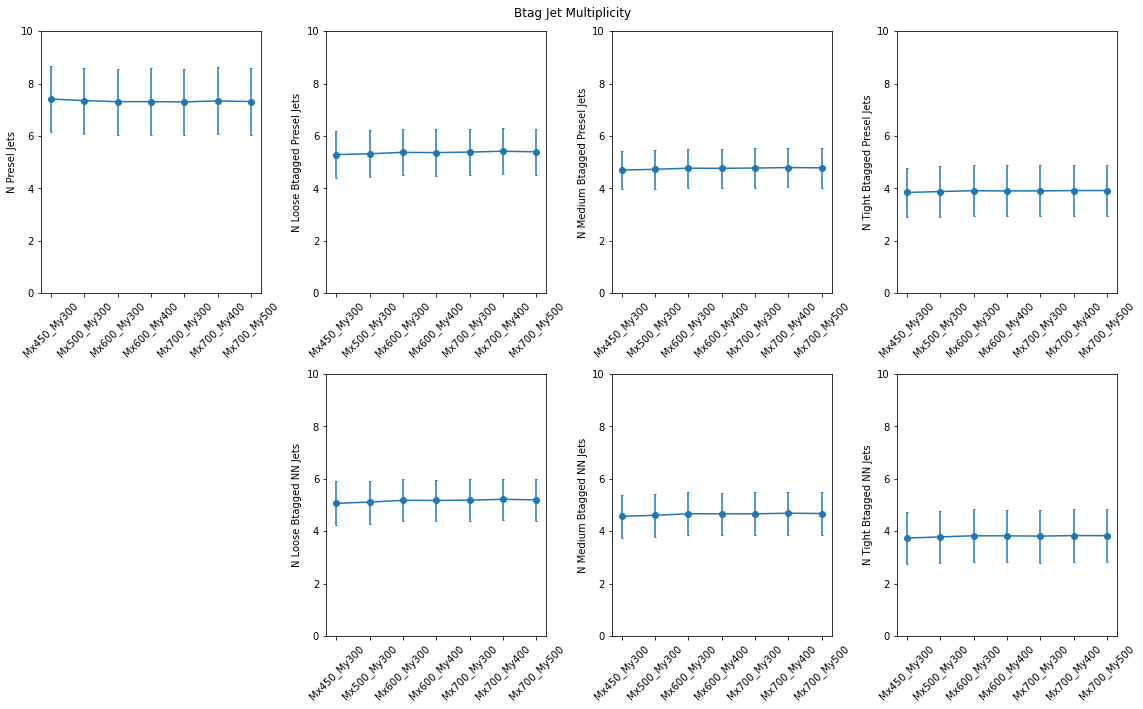

In [14]:
fig,axs = plt.subplots(nrows=2,ncols=4,figsize=(16,10))
    
graph_avgstd(treeiter.n_jet,xlabels=treeiter.sample,ylabel="N Presel Jets",figax=(fig,axs[0,0]),set=dict(ylim=(0,10)));
graph_avgstd(treeiter.nloose_btag_presel,xlabels=treeiter.sample,ylabel="N Loose Btagged Presel Jets",figax=(fig,axs[0,1]),set=dict(ylim=(0,10)));
graph_avgstd(treeiter.nmedium_btag_presel,xlabels=treeiter.sample,ylabel="N Medium Btagged Presel Jets",figax=(fig,axs[0,2]),set=dict(ylim=(0,10)));
graph_avgstd(treeiter.ntight_btag_presel,xlabels=treeiter.sample,ylabel="N Tight Btagged Presel Jets",figax=(fig,axs[0,3]),set=dict(ylim=(0,10)));

axs[1,0].set_visible(False)
graph_avgstd(treeiter.nloose_btag_nn,xlabels=treeiter.sample,ylabel="N Loose Btagged NN Jets",figax=(fig,axs[1,1]),set=dict(ylim=(0,10)));
graph_avgstd(treeiter.nmedium_btag_nn,xlabels=treeiter.sample,ylabel="N Medium Btagged NN Jets",figax=(fig,axs[1,2]),set=dict(ylim=(0,10)));
graph_avgstd(treeiter.ntight_btag_nn,xlabels=treeiter.sample,ylabel="N Tight Btagged NN Jets",figax=(fig,axs[1,3]),set=dict(ylim=(0,10)));

fig.suptitle("Btag Jet Multiplicity")
fig.tight_layout()

### NN Performance

We are using two neural networks (NN) in this analysis.

The first NN, the 6 Jet Classifier (NN6j), assigns a score to each combination of 6 jets based on kinematics and btag. The 6 jets with the highest score are selected and then fed into the second NN, the 2 Jet Classifier (NN2j). 

With 6 jets, there are 15 different ways to pair them into dijets ( nCr(6,2) ). The NN2j then uses kinematic variables to assign a score to all 15 possible pairings. 

We then need to select 3 of these pairings to reconstruct the 3 higgs in the event. There turns out only to be 15 different ways to select 3 pairs without duplicate. 

We assign a score to each of these groupings ( groups of 3 dijets ), by taking the normalized 2-norm ($\sqrt{\frac{s_1^2+s_2^2+s_3^2}{3}}$) of the 3 scores. The grouping with the highest score is then choosen. 

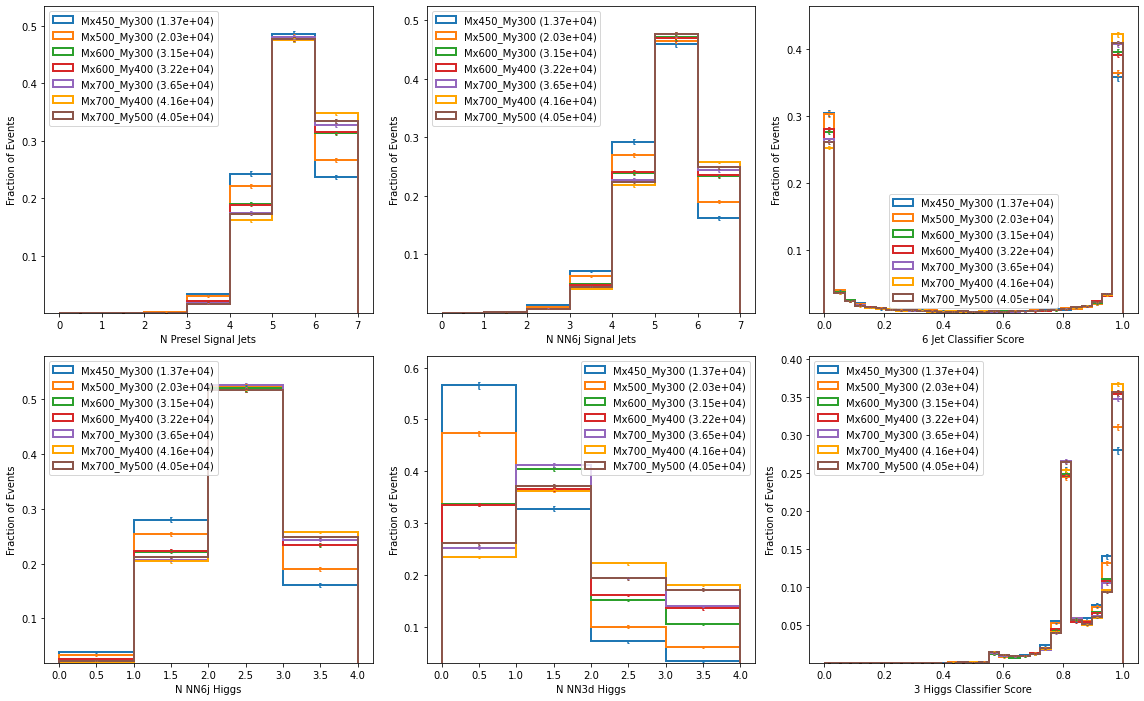

In [15]:
study.quick(treeiter, varlist=["nfound_presel", "nfound_nn","b_6j_score","nfound_nn_all_h", "nfound_nn_h","b_3d_score"], dim=(2, 3), density=1,scale=False)

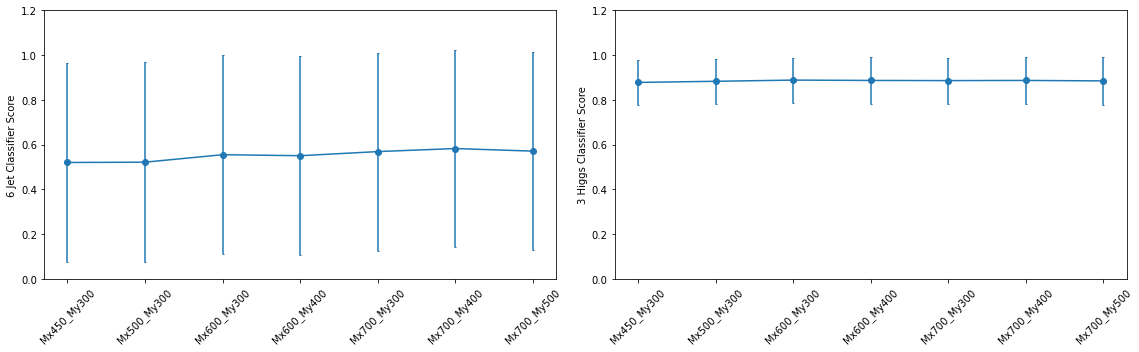

In [16]:
fig,axs = plt.subplots(nrows=1,ncols=2,figsize=(16,5))

graph_avgstd(treeiter.b_6j_score,xlabels=treeiter.sample,ylabel="6 Jet Classifier Score",figax=(fig,axs[0]),set=dict(ylim=(0,1.2)))
graph_avgstd(treeiter.b_3d_score,xlabels=treeiter.sample,ylabel="3 Higgs Classifier Score",figax=(fig,axs[1]),set=dict(ylim=(0,1.2)))

fig.tight_layout()

Looking at the average scores for the two NNs across different mass points, we can see that there isn't much a difference. 

In the signal jet multiplicity between preselected jets and the 6 jets selected by the NN6j, we can see that the shapes stay pretty similar. 

However, the total number of correctly paired signal jets by NN2j is much different than the total number of correct pairs present in the 6 jets selected by the NN6j. 

We can look at a better indicator of performance by considering how well the NNs replicate the true number of signal objects that they should find. 

For the NN6j, this is shown by looking at the signal jet multiplicity in the preselected jets vs. in the 6 jets selected. 

For the NN2j, this is shown by looking at the number of correct pairings in the 6 jets selected vs. the number of correct pairings by the NN.

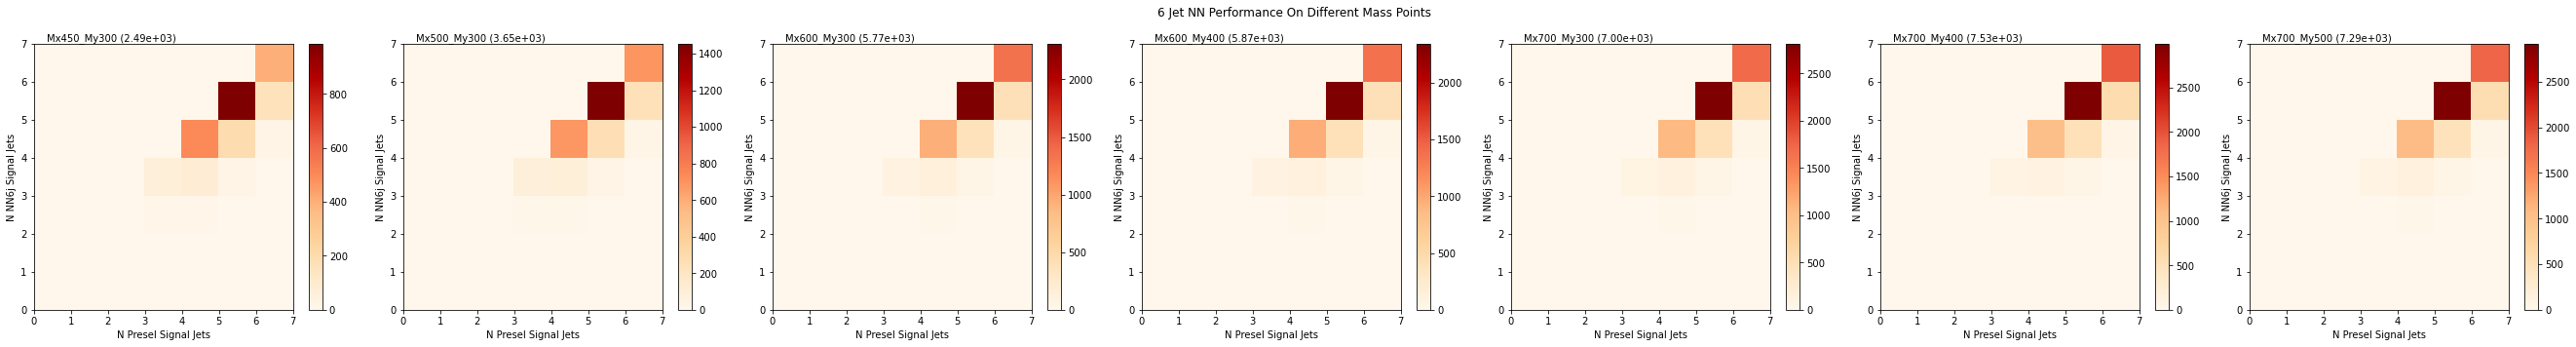

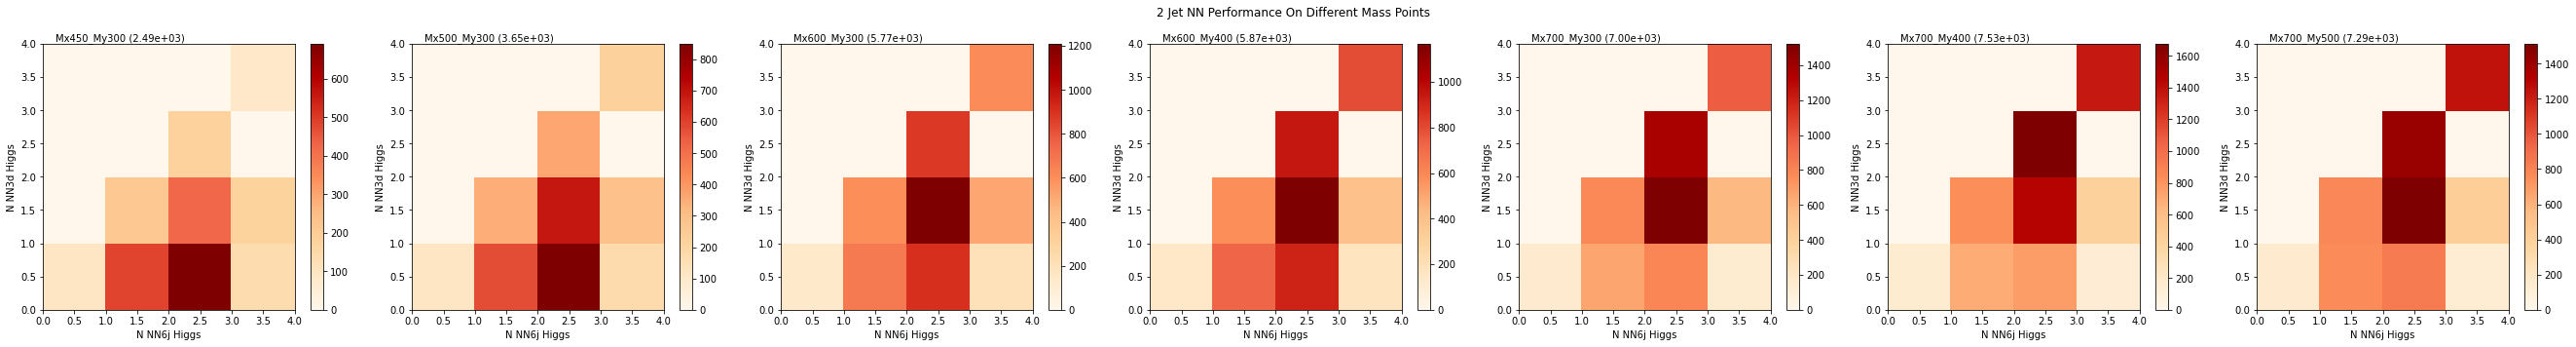

In [17]:
study.quick2d(treeiter,varlist=["nfound_presel","nfound_nn"],dim=(1,7),cmap='OrRd',title="6 Jet NN Performance On Different Mass Points",scale=False)
# study.quick2d(treeiter,varlist=["nfound_presel_h","nfound_nn_all_h"],dim=(1,7),cmap='OrRd')
study.quick2d(treeiter,varlist=["nfound_nn_all_h","nfound_nn_h"],dim=(1,7),cmap='OrRd',title="2 Jet NN Performance On Different Mass Points",scale=False)

We can also define an efficiency for each network as 

$$ E_{f} = N_{found}/N_{actual} $$ 

Looking at this efficiency, we can see that for the NN6J

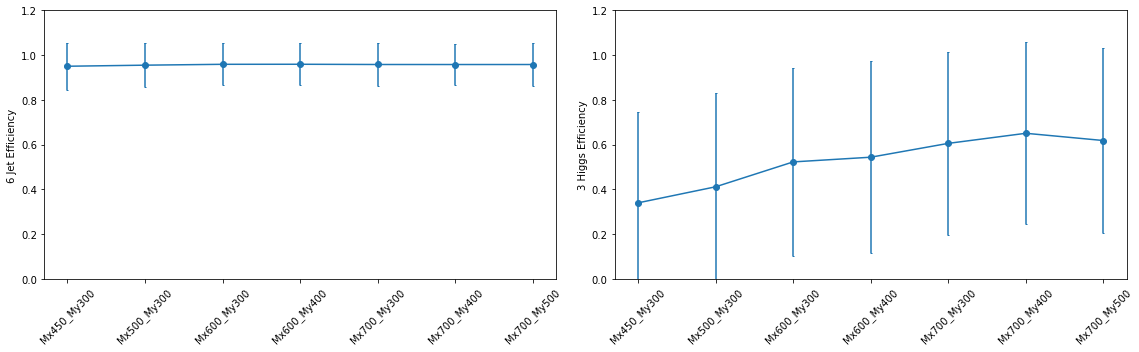

In [18]:
fig,axs = plt.subplots(nrows=1,ncols=2,figsize=(16,5))
    
graph_avgstd(treeiter.nn_6j_eff,ylabel="6 Jet Efficiency",xlabels=treeiter.sample,figax=(fig,axs[0]),set=dict(ylim=(0,1.2)));
graph_avgstd(treeiter.nn_3d_eff,ylabel="3 Higgs Efficiency",xlabels=treeiter.sample,figax=(fig,axs[1]),set=dict(ylim=(0,1.2)));

fig.tight_layout()

We can also look at how the NN2j performs on events where all 6 signal jets are correctly selected by the NN6j. 

In [10]:
sixbiter = EventFilter("sixb",nfound_nn=6).filter(treeiter)

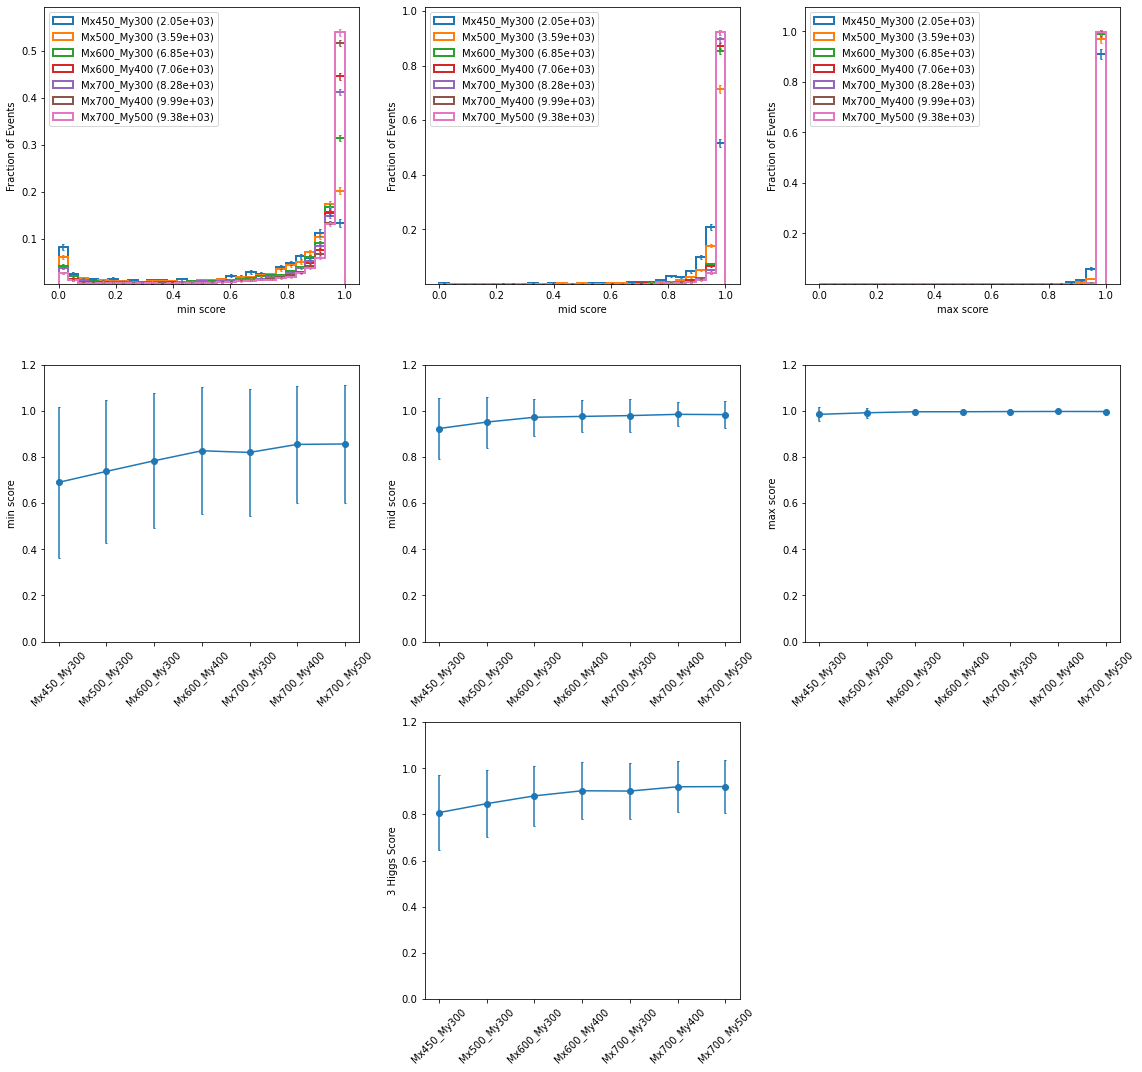

In [26]:
fig,axs = plt.subplots(nrows=3,ncols=3,figsize=(16,15))

varlist = ['min score','mid score','max score']
for i,var in enumerate(varlist):
    datalist = [ data.scores[:,i] for data in truH_list ]
    hist_multi(datalist,labels=sixbiter.sample,xlabel=var,density=1,lumikey=None,figax=(fig,axs[0,i]),bins=np.linspace(0,1,30))
    graph_avgstd(datalist,xlabels=sixbiter.sample,ylabel=var,figax=(fig,axs[1,i]),set=dict(ylim=(0,1.2)))

norm_score = [ ak.sum(data.scores**2/3,axis=-1) for data in truH_list ]
graph_avgstd(norm_score,xlabels=treeiter.sample,ylabel="3 Higgs Score",set=dict(ylim=(0,1.2)),figax=(fig,axs[2,1]))
fig.tight_layout()

axs[2,0].set_visible(False)
axs[2,2].set_visible(False)

We can see that the NN2j starts to perform differently for the lowest scoring dijet.